In [45]:
import json
import os
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.font_manager import FontProperties

In [36]:
file_path = "../data/processed/hist_corp_contexts.json"
with open(file_path, "r", encoding="utf-8") as file:
    metadata = json.load(file)

# 將前綴與後綴分類
def classify_prefix_suffix(metadata, target_char="定"):
    prefix_data = {}
    suffix_data = {}
    
    for word, details in metadata.items():
        if word.startswith(target_char): 
            prefix_data[word] = details
        elif word.endswith(target_char):  
            suffix_data[word] = details
    
    return prefix_data, suffix_data

# 提取前綴與後綴數據
prefix_data, suffix_data = classify_prefix_suffix(metadata)
print(f"前綴數量：{len(prefix_data)}，後綴數量：{len(suffix_data)}")

前綴數量：30，後綴數量：27


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ethanyt/guwenbert-base")
model = AutoModel.from_pretrained("ethanyt/guwenbert-base")

In [ ]:
# 提取單字「定」的上下文化嵌入
def extract_single_char_embedding(metadata, target_char="定"):
    char_embeddings = {}
    
    for word, contexts in metadata.items():
        embeddings = []
        for context in contexts.get("cbeta", []):  
            text = f"{context['left']}{word}{context['right']}"  
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
            
            input_ids = inputs["input_ids"].squeeze().tolist()
            indices = [i for i, token_id in enumerate(input_ids) if token_id == tokenizer.convert_tokens_to_ids(target_char)]
            if not indices:
                continue
            
            token_embed = outputs.last_hidden_state[:, indices, :].squeeze().numpy()
            embeddings.append(token_embed)
        
        if embeddings:
            char_embeddings[word] = np.vstack(embeddings)  
        else:
            char_embeddings[word] = None  
    return char_embeddings

# 為前綴與後綴生成嵌入
prefix_char_embeddings = extract_single_char_embedding(prefix_data, target_char="定")
suffix_char_embeddings = extract_single_char_embedding(suffix_data, target_char="定")

In [ ]:
# # 保存嵌入到 .pkl 文件
# def save_embeddings_to_pkl(prefix_embeddings, suffix_embeddings, prefix_file="prefix_embeddings.pkl", suffix_file="suffix_embeddings.pkl"):
#     with open(prefix_file, "wb") as f:
#         pickle.dump(prefix_embeddings, f)
#     with open(suffix_file, "wb") as f:
#         pickle.dump(suffix_embeddings, f)

# save_embeddings_to_pkl(prefix_char_embeddings, suffix_char_embeddings)

In [41]:
def load_embeddings_from_pkl(prefix_file="prefix_embeddings.pkl", suffix_file="suffix_embeddings.pkl"):
    with open(prefix_file, "rb") as f:
        prefix_embeddings = pickle.load(f)
    with open(suffix_file, "rb") as f:
        suffix_embeddings = pickle.load(f)    
    return prefix_embeddings, suffix_embeddings

prefix_char_embeddings, suffix_char_embeddings = load_embeddings_from_pkl(
    prefix_file="prefix_embeddings.pkl",
    suffix_file="suffix_embeddings.pkl"
)

In [ ]:
def aggregate_single_char_by_dynasty(metadata, char_embeddings):
    dynasty_embeddings = {}

    for word, contexts in metadata.items():
        if word not in char_embeddings or char_embeddings[word] is None:
            continue  

        embeddings = char_embeddings[word]

        for source, entries in contexts.items():  
            for i, context in enumerate(entries):
                dynasty = context['dynasty']

                if i < len(embeddings):
                    if dynasty not in dynasty_embeddings:
                        dynasty_embeddings[dynasty] = []
                    dynasty_embeddings[dynasty].append(embeddings[i])

    return {dynasty: np.mean(np.vstack(embs), axis=0) for dynasty, embs in dynasty_embeddings.items() if embs}


# 聚合前綴與後綴的單字嵌入
prefix_dynasty_char_embeddings = aggregate_single_char_by_dynasty(prefix_data, prefix_char_embeddings)
suffix_dynasty_char_embeddings = aggregate_single_char_by_dynasty(suffix_data, suffix_char_embeddings)

In [46]:
dynasty_order = ["先秦", "漢", "魏晉南北", "唐五代十國", "宋元", "明", "清", "民國"]

# 計算相鄰朝代語義相似度
def compute_token_similarity(dynasty_embeddings, dynasty_order):
    similarities = {}
    for i in range(len(dynasty_order) - 1):
        d1, d2 = dynasty_order[i], dynasty_order[i + 1]
        if d1 in dynasty_embeddings and d2 in dynasty_embeddings:
            sim = cosine_similarity(
                [dynasty_embeddings[d1]],  # 第1個朝代的語義中心
                [dynasty_embeddings[d2]]   # 第2個朝代的語義中心
            )[0][0]
            similarities[f"{d1}-{d2}"] = sim
    return similarities

prefix_similarity = compute_token_similarity(prefix_dynasty_char_embeddings, dynasty_order)
suffix_similarity = compute_token_similarity(suffix_dynasty_char_embeddings, dynasty_order)

print("前綴語義相似度：", prefix_similarity)
print("後綴語義相似度：", suffix_similarity)

前綴語義相似度： {'先秦-漢': np.float32(0.9994653), '漢-魏晉南北': np.float32(0.9997136), '魏晉南北-唐五代十國': np.float32(0.9997323), '唐五代十國-宋元': np.float32(0.9997696), '宋元-明': np.float32(0.9998818), '明-清': np.float32(0.99995774), '清-民國': np.float32(0.99977684)}
後綴語義相似度： {'先秦-漢': np.float32(0.9991356), '漢-魏晉南北': np.float32(0.99959505), '魏晉南北-唐五代十國': np.float32(0.99975145), '唐五代十國-宋元': np.float32(0.9997545), '宋元-明': np.float32(0.9998619), '明-清': np.float32(0.9999615), '清-民國': np.float32(0.99977463)}


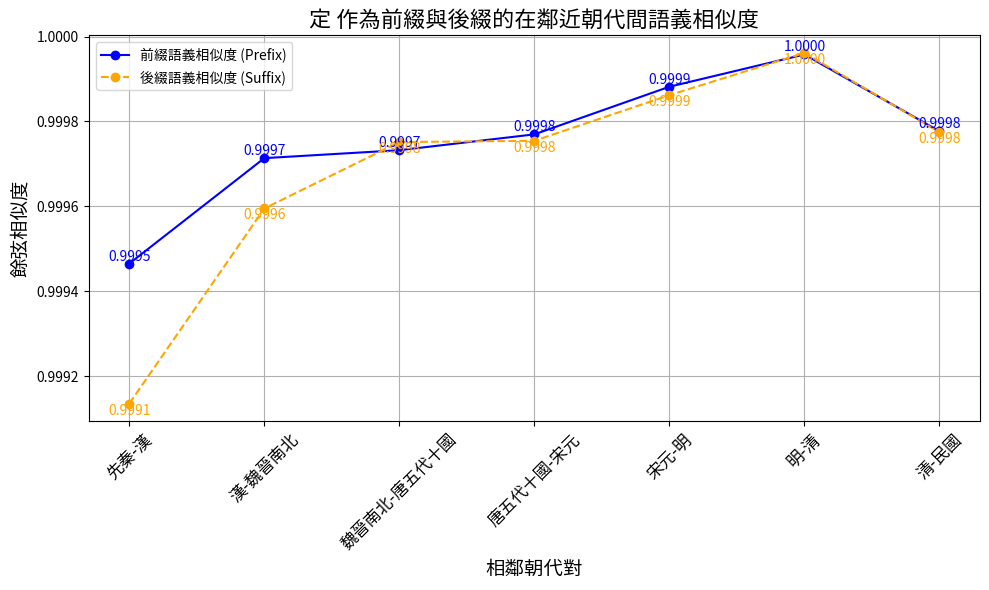

In [48]:
font_path = "../data/fonts/TaipeiSansTCBeta-Regular.ttf"
custom_font = FontProperties(fname=font_path)

def plot_adjacent_similarity(prefix_similarities, suffix_similarities, title="語義相似度", font=custom_font):
    x_prefix = list(prefix_similarities.keys())  # 前綴的朝代對
    y_prefix = list(prefix_similarities.values())  # 前綴的語義相似度
    
    x_suffix = list(suffix_similarities.keys())  # 後綴的朝代對
    y_suffix = list(suffix_similarities.values())  # 後綴的語義相似度

    plt.figure(figsize=(10, 6))
    
    # 繪製前綴語義相似度
    plt.plot(x_prefix, y_prefix, label="前綴語義相似度 (Prefix)", marker='o', linestyle='-', color='blue')
    
    # 繪製後綴語義相似度
    plt.plot(x_suffix, y_suffix, label="後綴語義相似度 (Suffix)", marker='o', linestyle='--', color='orange')
    
    # 添加朝代對到 X 軸
    plt.xticks(rotation=45, fontproperties=font, fontsize=12)
    
    # 添加標題與軸標籤
    plt.title(title, fontproperties=font, fontsize=16)
    plt.xlabel("相鄰朝代對", fontproperties=font, fontsize=14)
    plt.ylabel("餘弦相似度", fontproperties=font, fontsize=14)
    
    # 添加數值標籤
    for i, value in enumerate(y_prefix):
        plt.text(i, value, f"{value:.4f}", fontproperties=font, fontsize=10, ha='center', va='bottom', color='blue')
    for i, value in enumerate(y_suffix):
        plt.text(i, value, f"{value:.4f}", fontproperties=font, fontsize=10, ha='center', va='top', color='orange')

    # 添加圖例
    plt.legend(prop=font, fontsize=12)
    
    # 添加網格線
    plt.grid()
    
    plt.tight_layout()
    plt.show()

# 語義相似度數據
prefix_similarity = {'先秦-漢': 0.9994653, '漢-魏晉南北': 0.9997136, '魏晉南北-唐五代十國': 0.9997323, 
                     '唐五代十國-宋元': 0.9997696, '宋元-明': 0.9998818, '明-清': 0.99995774, '清-民國': 0.99977684}
suffix_similarity = {'先秦-漢': 0.9991356, '漢-魏晉南北': 0.99959505, '魏晉南北-唐五代十國': 0.99975145, 
                     '唐五代十國-宋元': 0.9997545, '宋元-明': 0.9998619, '明-清': 0.9999615, '清-民國': 0.99977463}

# 繪製前綴和後綴的相似度在同一張圖上
plot_adjacent_similarity(prefix_similarity, suffix_similarity, title="定 作為前綴與後綴的在鄰近朝代間的語義相似度")